# Part B: Exploration + Data Preprocessing

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

pd.set_option('display.max_columns', None)

Booking data treatment

In [247]:
original_booking_data = pd.read_csv('scraped_data/booking_data.csv')
original_booking_data.head(3)

print(f'Shape for booking data: {original_booking_data.shape}')
print(f'Nulls before eliminating: \n{original_booking_data.isnull().sum()}')

booking_data = original_booking_data.drop(['Card Deal'], axis=1) # Decided to eliminate this column since more than 80% of the data is missing

# Eliminating nulls in the data
booking_data = booking_data[booking_data['Payment Policy'].notnull()]
booking_data = booking_data[booking_data['Cancellation Policy'].notnull()]
booking_data = booking_data[booking_data['Bed Type'].notnull()]

print(f'\nNulls after treatment: {booking_data.isnull().sum().sum()}')
print(f'Shape for booking data after treatment: {booking_data.shape}')

# Converting data types to datetime, if needed
booking_data['Date of search'] = pd.to_datetime(booking_data['Date of search'])
booking_data['Checkin'] = pd.to_datetime(booking_data['Checkin'])
booking_data['Checkout'] = pd.to_datetime(booking_data['Checkout'])

booking_data = booking_data.reset_index(drop=True)
booking_data.head(2)

Shape for booking data: (11941, 22)
Nulls before eliminating: 
Hotel Name                0
Score                     0
Distance to Center        0
Price                     0
Taxes and Fees            0
Total Price               0
Nights and Adults         0
Card Deal              9410
Stars                   537
Subway Access             0
Neighborhood              0
Room Type                 0
Bed Type                  5
Cancellation Policy    4461
Payment Policy         9760
Classification            0
Number of Reviews         0
Date of search            0
Checkin                   0
Checkout                  0
ttt                       0
los                       0
dtype: int64

Nulls after treatment: 0
Shape for booking data after treatment: (2181, 21)


,Hotel Name,Score,Distance to Center,Price,Taxes and Fees,Total Price,Nights and Adults,Stars,Subway Access,Neighborhood,Room Type,Bed Type,Cancellation Policy,Payment Policy,Classification,Number of Reviews,Date of search,Checkin,Checkout,ttt,los
0,SpringHill Suites by Marriott New York Midtown...,8.1,1.9,279,45,324.0,"1 night,2 adults",3.0,True,Manhattan,King Studio,Entire studio•1 bathroom•18m²,Free cancellation,No prepayment needed– pay at the property,Very Good,1027,2024-06-20,2024-06-21,2024-06-22,1,1
1,Hilton Club The Central at 5th New York,8.9,1.3,1410,211,1621.0,"1 night,2 adults",3.0,True,Midtown East,One-Bedroom Premier King Suite with Sofa Bed,Private suite,Free cancellation,No prepayment needed– pay at the property,Excellent,607,2024-06-20,2024-06-21,2024-06-22,1,1


Expedia data treatment

In [248]:
original_expedia_data = pd.read_csv('scraped_data/expedia_data.csv')

print(f'Shape for expedia data: {original_expedia_data.shape}')
print(f'Nulls before eliminating: \n{original_expedia_data.isnull().sum()}')

expedia_data = original_expedia_data.drop(columns=['Room Type', 'Bed Type'], axis=1) # Eliminating these columns since they are not present in the expedia data
                                                                                     # The page does not let scrape that data
expedia_data = expedia_data.dropna(subset=['Cancellation Policy', 'Payment Policy', 'Classification']) # Eliminating nulls in the data

print(f'\nNulls after treatment: {expedia_data.isnull().sum().sum()}')
print(f'Shape for expedia after treatment: {expedia_data.shape}')
expedia_data['Date of search'] = pd.to_datetime(expedia_data['Date of search'])
expedia_data['Checkin'] = pd.to_datetime(expedia_data['Checkin'])
expedia_data['Checkout'] = pd.to_datetime(expedia_data['Checkout'])

expedia_data['Total Price'] = expedia_data['Total Price'].replace(',', '', regex=True).astype(int)

# Changing column names for both booking and expedia
new_expedia_columns = [column.replace(' ', '_').lower() for column in expedia_data.columns]
new_booking_columns = [column.replace(' ', '_').lower() for column in booking_data.columns]
expedia_data.columns = new_expedia_columns
booking_data.columns = new_booking_columns

expedia_data = expedia_data.reset_index(drop=True)
expedia_data.head(2)

Shape for expedia data: (38777, 17)
Nulls before eliminating: 
Hotel Name                 0
Price Before Taxes         0
Score                      0
Classification            35
Number of Reviews          0
Room Type              38777
Bed Type               38777
Neighborhood               0
District                   0
Cancellation Policy    26220
Payment Policy         31651
Total Price                0
Date of search             0
Checkin                    0
Checkout                   0
ttt                        0
los                        0
dtype: int64

Nulls after treatment: 0
Shape for expedia after treatment: (7126, 15)


,hotel_name,price_before_taxes,score,classification,number_of_reviews,neighborhood,district,cancellation_policy,payment_policy,total_price,date_of_search,checkin,checkout,ttt,los
0,Moxy NYC Chelsea,220,8.6,Excellent,1002,Chelsea,Chelsea,Fully refundable,Fully refundable,286,2024-06-20,2024-06-21,2024-06-22,1,1
1,Moxy NYC Chelsea,220,8.6,Excellent,1002,Chelsea,Chelsea,Fully refundable,Fully refundable,286,2024-06-20,2024-06-21,2024-06-23,1,2


In [249]:
print(f'Expedia data columns: {expedia_data.columns}')
print(f'Booking data columns: {booking_data.columns}')

Expedia data columns: Index(['hotel_name', 'price_before_taxes', 'score', 'classification',
       'number_of_reviews', 'neighborhood', 'district', 'cancellation_policy',
       'payment_policy', 'total_price', 'date_of_search', 'checkin',
       'checkout', 'ttt', 'los'],
      dtype='object')
Booking data columns: Index(['hotel_name', 'score', 'distance_to_center', 'price', 'taxes_and_fees',
       'total_price', 'nights_and_adults', 'stars', 'subway_access',
       'neighborhood', 'room_type', 'bed_type', 'cancellation_policy',
       'payment_policy', 'classification', 'number_of_reviews',
       'date_of_search', 'checkin', 'checkout', 'ttt', 'los'],
      dtype='object')


- Creating for both expedia and booking data distribution graphs of:
1. Number of reviews
2. Hotel rating in reviews
3. Prices

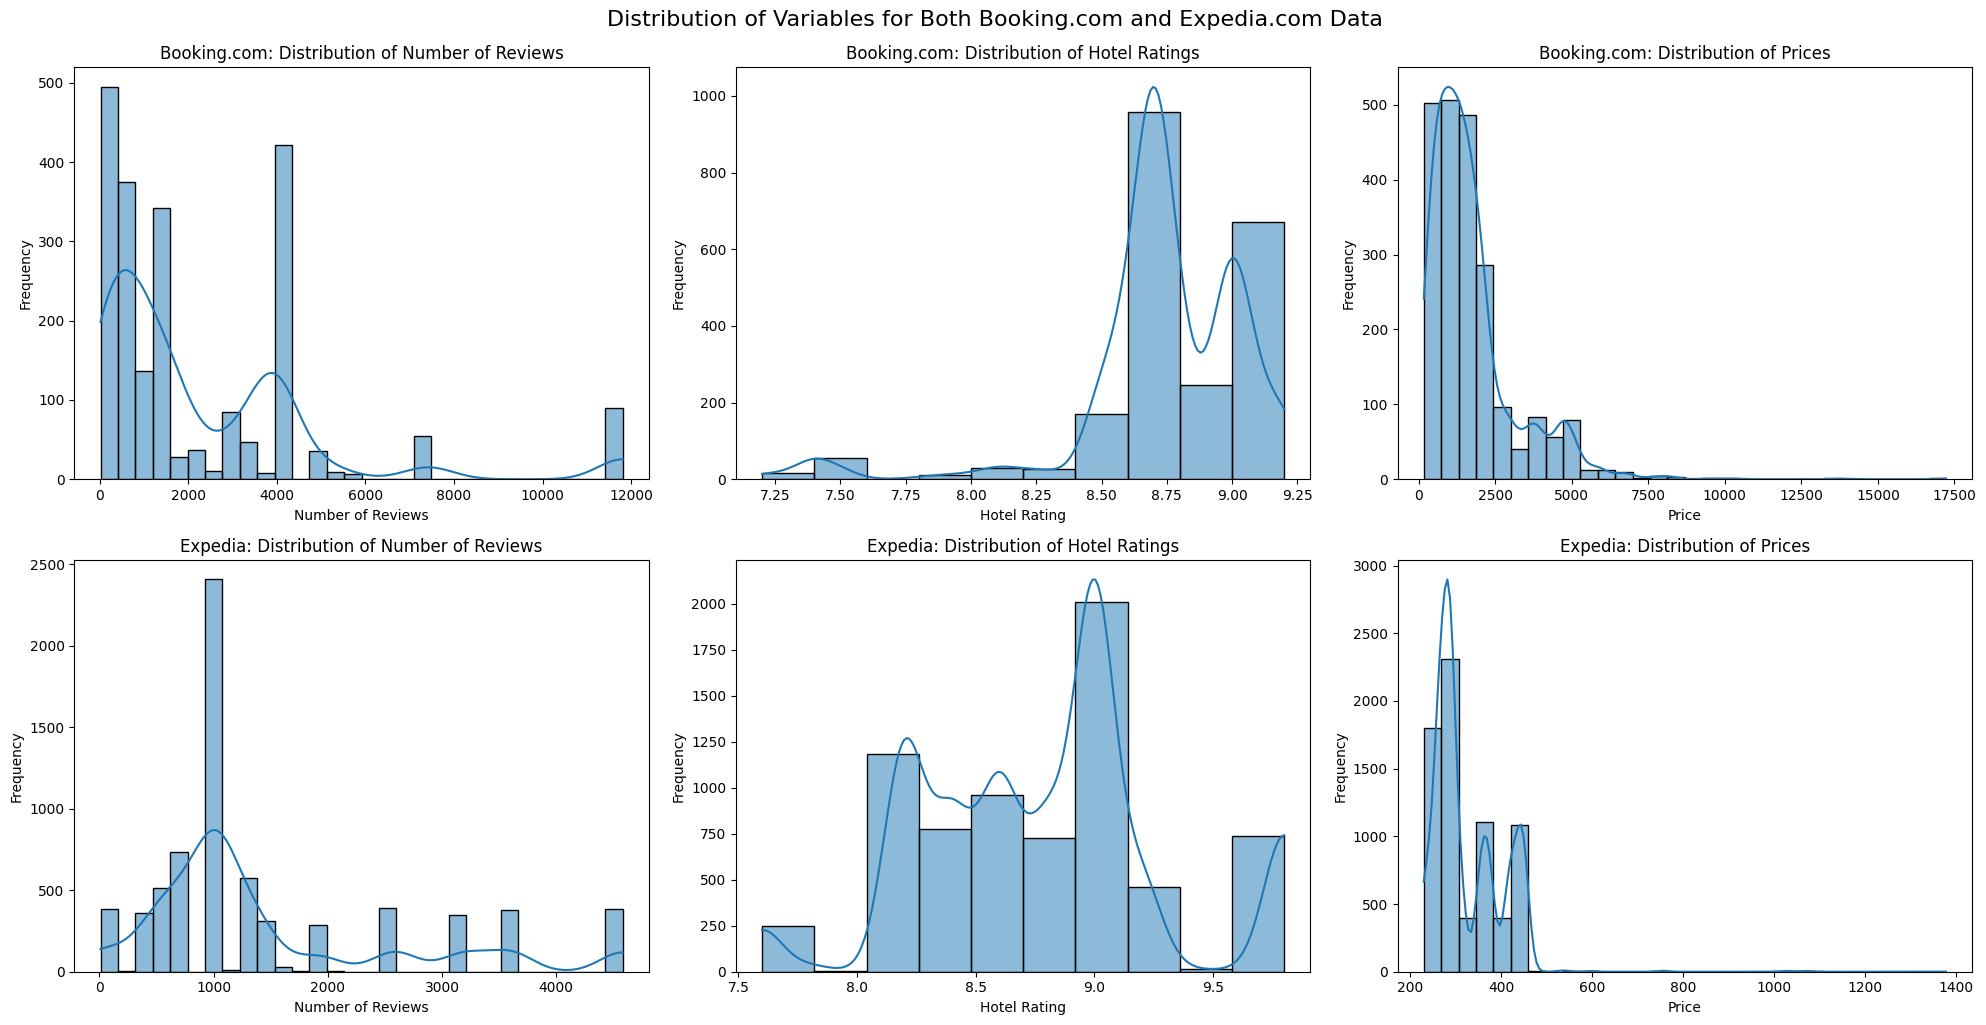

In [250]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Booking.com data plots
# 1. Number of reviews
sns.histplot(booking_data['number_of_reviews'].astype(int), bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Booking.com: Distribution of Number of Reviews')
axs[0, 0].set_xlabel('Number of Reviews')
axs[0, 0].set_ylabel('Frequency')

# 2. Hotel rating in reviews
sns.histplot(booking_data['score'].astype(float), bins=10, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Booking.com: Distribution of Hotel Ratings')
axs[0, 1].set_xlabel('Hotel Rating')
axs[0, 1].set_ylabel('Frequency')

# 3. Prices
sns.histplot(booking_data['total_price'].astype(float), bins=30, kde=True, ax=axs[0, 2])
axs[0, 2].set_title('Booking.com: Distribution of Prices')
axs[0, 2].set_xlabel('Price')
axs[0, 2].set_ylabel('Frequency')

# Expedia data plots
# 1. Number of reviews
sns.histplot(expedia_data['number_of_reviews'].astype(int), bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Expedia: Distribution of Number of Reviews')
axs[1, 0].set_xlabel('Number of Reviews')
axs[1, 0].set_ylabel('Frequency')

# 2. Hotel rating in reviews
sns.histplot(expedia_data['score'].astype(float), bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Expedia: Distribution of Hotel Ratings')
axs[1, 1].set_xlabel('Hotel Rating')
axs[1, 1].set_ylabel('Frequency')

# 3. Prices
sns.histplot(expedia_data['total_price'].astype(float), bins=30, kde=True, ax=axs[1, 2])
axs[1, 2].set_title('Expedia: Distribution of Prices')
axs[1, 2].set_xlabel('Price')
axs[1, 2].set_ylabel('Frequency')

plt.tight_layout()
fig.suptitle('Distribution of Variables for Both Booking.com and Expedia.com Data', fontsize=16, y=1.02)
plt.show()

- Remove from data hotels that based on price column are an outlier (using 
Tukey 1.5IQR method).

In [251]:
def remove_outliers(df, column):
    """
    Removes outliers from a dataframe based on the IQR method for a specified column.

    Parameters:
    - df (pd.DataFrame): The dataframe from which outliers will be removed.
    - column (str): The name of the column to check for outliers.

    Returns:
    - pd.DataFrame: A new dataframe with outliers removed from the specified column.

    The function calculates the Interquartile Range (IQR) for the given column and defines
    outliers as any values outside 1.5 * IQR above the third quartile or below the first quartile.
    It returns a dataframe excluding these outliers.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Removing outliers in booking and expedia data
booking_data_no_outliers = remove_outliers(booking_data, 'total_price')
expedia_data_no_outliers = remove_outliers(expedia_data, 'total_price')

print(f'Booking data shape without outliers: {booking_data_no_outliers.shape}')
print(f'Expedia data shape without outliers: {expedia_data_no_outliers.shape}')

Booking data shape without outliers: (1996, 21)
Expedia data shape without outliers: (7102, 15)


- Convert variables with Ordinal characteristic to numbers with order relation 
(for example Good < Very Good<Excellent)

Booking data

In [252]:
booking_data_no_outliers = booking_data_no_outliers.copy()
print(f'Unique values for review class before treatment: {booking_data_no_outliers["classification"].unique()}')

# Eliminating all the rows where Review Class column says 'Review score'
booking_data_no_outliers = booking_data_no_outliers[booking_data_no_outliers['classification'] != 'Review score']

ordinal_mapping_booking = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4,
}

booking_data_no_outliers['classification'] = booking_data_no_outliers['classification'].map(ordinal_mapping_booking)
print(f'Unique values for review class after treatment: {booking_data_no_outliers["classification"].unique()}')

Unique values for review class before treatment: ['Very Good' 'Excellent' 'Wonderful' 'Good']
Unique values for review class after treatment: [2 3 4 1]


Expedia data

In [253]:
expedia_data_no_outliers = expedia_data_no_outliers.copy()
print(f'Unique values for review class before treatment: {expedia_data_no_outliers["classification"].unique()}')

ordinal_mapping_expedia = {
    'Good': 0,
    'Very Good': 1,
    'Excellent': 2,
    'Wonderful': 3,
    'Exceptional': 4,
}

expedia_data_no_outliers['classification'] = expedia_data_no_outliers['classification'].map(ordinal_mapping_expedia)
print(f'Unique values for review class after treatment: {expedia_data_no_outliers["classification"].unique()}')

Unique values for review class before treatment: ['Excellent' 'Very Good' 'Wonderful' 'Exceptional' 'Good']
Unique values for review class after treatment: [2 1 3 4 0]


- Additional example – the bed type by order relation. First you have to 
calculate the bed types (distinct) out of total data you have). And then King 
Room should get higher value then Queen Room for example.

Since there are many different types of beds retrieven from the scraping, I have decided to encode these columns too in the following part of the project requirements.

Booking data

In [254]:
def encoding(df, columns_to_encode):
    """
    One-hot encodes specified columns of a DataFrame, except for columns related to hotel names which are label encoded.

    This function iterates over a list of columns to encode in a given DataFrame. If a column is related to hotel names,
    it is label encoded instead of one-hot encoded to avoid creating a large number of binary columns. For other columns,
    one-hot encoding is applied, and the first category is dropped to avoid multicollinearity. The original columns to be
    encoded are dropped from the DataFrame, and the encoded columns are appended.

    Parameters:
    - df (pd.DataFrame): The DataFrame to encode.
    - columns_to_encode (list of str): A list of column names in the DataFrame to be encoded.

    Returns:
    - pd.DataFrame: A DataFrame with the specified columns encoded and original columns dropped.
    """
    encoded_dfs = []

    for column in columns_to_encode:
        if 'hotel_name' in column:  # Skip columns related to hotel names
            # Use LabelEncoder for hotel_name
            encoder = LabelEncoder()
            encoded_data = encoder.fit_transform(df[column])
            encoded_df = pd.DataFrame(encoded_data, columns=[column])
            encoded_dfs.append(encoded_df)
            continue
        
        # One-hot encode for the rest of the columns
        encoder = OneHotEncoder(drop='first')
        encoded_data = encoder.fit_transform(df[[column]])
        feature_names = encoder.get_feature_names_out(input_features=[column]) # Gettibng the feature names for the encoded columns

        # DataFrame with the encoded data and the correct feature names
        encoded_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)
        encoded_dfs.append(encoded_df)

    # Drop the original columns to encode from the dataframe
    data = df.drop(columns=columns_to_encode).reset_index(drop=True)
    data = pd.concat([data] + encoded_dfs, axis=1)  # Final data concatenation

    return data

# Encoding the columns of expedia and booking data
columns_to_encode_booking = ['hotel_name', 'nights_and_adults', 'neighborhood', 'room_type', 'bed_type', 'cancellation_policy', 'payment_policy']
columns_to_encode_expedia = ['hotel_name', 'neighborhood', 'district', 'cancellation_policy', 'payment_policy'] # The column cancellation policy will be eliminated since all the values are the same

booking_data_encoded = encoding(booking_data_no_outliers, columns_to_encode_booking)
expedia_data_encoded = encoding(expedia_data_no_outliers, columns_to_encode_expedia)

print(f'Shape of booking data after encoding: {booking_data_encoded.shape}')
print(f'Shape of expedia data after encoding: {expedia_data_encoded.shape}')

Shape of booking data after encoding: (1996, 144)
Shape of expedia data after encoding: (7102, 20)


- PairGrid (of seaborn library) for the variables in booking and expedia data.

Booking data numerical variables pairplot

**Insights from the plots:**

For the Expedia data, we observe a positive correlation between the total price and the score, indicating that higher-rated hotels tend to be more expensivem, there is also a relationship between the number of reviews and the total price, sugesting that hotels with more reviews are generally higher priced. The classification variable, shows a moderate impact on the total price, with higher-classification hotels tending to charge more.

In the Booking data, a clear relationship exists between price and taxes_and_fees, with higher taxes and fees corresponding to higher overall prices, this is expected since to calculate the total price, the taxes column is needed. The total price also shows a correlation with the stars, similar to the Expedia data, implying that well-reviewed and higher-star hotels command higher prices, but in the contrary to the expedia data, the number_of_reviews and the total_price columns have a negative correlation, meaning that in this dataset, hotels with grater number of reviews tends to have lower price. 

In [255]:
# Since all values for the column 'subway_acces' are the same, we can eliminate it
booking_data_encoded = booking_data_encoded.drop(columns='subway_access')

In [256]:
# # Define the columns to be visualized in the PairGrid
# booking_data_columns_pairgrid = [
#     'score', 'distance_to_center', 'price', 'taxes_and_fees', 
#     'stars', 'classification', 'number_of_reviews', 'total_price'
# ]

# # Creating the PairGrid for the numerical columns of the booking data
# grid = sns.PairGrid(data=booking_data_encoded[booking_data_columns_pairgrid])
# grid = grid.map_lower(plt.scatter, color='darkred')  # Scatter plot for the lower triangle
# grid = grid.map_diag(sns.histplot, color='darkred', edgecolor="k", alpha=0.7)  # Histogram for the diagonal
# plt.subplots_adjust(top=0.95)
# plt.suptitle('PairGrid Visualization of Booking Data', fontsize=20, color='darkred')
# sns.set_style("whitegrid")
# plt.show()

Expedia data numerical variables pairplot

In [257]:
# expedia_data_columns_pairgrid = ['price_before_taxes', 'score', 'classification', 'number_of_reviews', 'total_price']

# # Creating the PairGrid for the numerical columns of the expedia data
# grid = sns.PairGrid(data=expedia_data_encoded[expedia_data_columns_pairgrid])
# grid = grid.map_lower(plt.scatter, color='navy')
# grid = grid.map_diag(sns.histplot, color='navy', edgecolor="k", alpha=0.7)
# plt.subplots_adjust(top=0.95)
# plt.suptitle('PairGrid Visualization of Expedia Data', fontsize=20, color='navy')
# sns.set_style("whitegrid")

# plt.show()

# Part C – prediction of rooms prices

Implementation of various regression models using a function and plotting the residuals as needed

Since the date_of_search, checkin and checkout are truly needed for the ML models, I decided to encode them separating in columns for dayofweek, moth and year

In [258]:
# Function to convert date columns and extract day of the week, month, and year
def convert_date_columns(df, columns):
    """
    Converts specified date columns in a DataFrame to numerical values representing the day of the week, month, and year.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the date columns to be converted.
        columns (list of str): A list of column names in `df` that are to be converted from datetime objects to separate columns for day of the week, month, and year.

    Returns:
        pd.DataFrame: A DataFrame with the original date columns replaced by three new columns for each original column, indicating the day of the week, month, and year, respectively.

    Note:
        The original date columns specified in `columns` are dropped from the returned DataFrame.
    """
    for column in columns:
        # Ensuring the column is in datetime format
        df[column] = pd.to_datetime(df[column])
        
        # Extracting day of the week, month, and year
        df[f'{column}_dayofweek'] = df[column].dt.dayofweek
        df[f'{column}_month'] = df[column].dt.month
        df[f'{column}_year'] = df[column].dt.year
    
    # df.drop(columns=columns, inplace=True) # Eliminating the original columns
    return df

# Columns to convert
date_columns = ['date_of_search', 'checkin', 'checkout']
booking_data_encoded = convert_date_columns(booking_data_encoded, date_columns)
expedia_data_encoded = convert_date_columns(expedia_data_encoded, date_columns)

# Splitting the data into X and y for both booking and expedia
X_booking = booking_data_encoded.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
X_expedia = expedia_data_encoded.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])

y_booking = booking_data_encoded['total_price']
y_expedia = expedia_data_encoded['total_price']

In [259]:
def plot_residuals(y_train, y_train_pred, y_test, y_test_pred, model_name):
    """
    Plots the residuals of training and testing datasets for a given model.

    Parameters:
        y_train (array-like): The actual values of the target variable in the training dataset.
        y_train_pred (array-like): The predicted values of the target variable in the training dataset.
        y_test (array-like): The actual values of the target variable in the testing dataset.
        y_test_pred (array-like): The predicted values of the target variable in the testing dataset.
        model_name (str): The name of the model for which residuals are being plotted.

    Returns:
        None: This function only generates plots and does not return any value.
    """
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    sns.residplot(x=y_train, y=y_train_pred - y_train, lowess=True, color="g")
    plt.title(f'{model_name} - Train Residuals')
    plt.xlabel('Actual Prices')
    plt.ylabel('Residuals')

    plt.subplot(1, 2, 2)
    sns.residplot(x=y_test, y=y_test_pred - y_test, lowess=True, color="b")
    plt.title(f'{model_name} - Test Residuals')
    plt.xlabel('Actual Prices')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

def train_and_evaluate_models(X, y, residual_plots=True, importances=True):
    """
    Trains multiple regression models on a given dataset, evaluates their performance, and optionally plots residuals and outputs feature importances.

    Parameters:
        X (pd.DataFrame): The feature dataset.
        y (pd.Series): The target variable.
        residual_plots (bool, optional): If True, plots the residuals for each model. Defaults to True.
        importances (bool, optional): If True, calculates and stores the feature importances for models that support it. Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the performance metrics of each model, including RMSE, MAE, R2 scores for both training and testing datasets, best parameters for each model, and optionally feature importances.
    """
    # Splitting the data into training and testing sets (70-30 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize models with hyperparameters to tune with grid search
    param_grids = {
        'Linear Regression': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'criterion': ['absolute_error', 'squared_error']
        },
        'K-Nearest Neighbors': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        'AdaBoost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }

    # Models dictionary, from sklearn
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'K-Nearest Neighbors': KNeighborsRegressor(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42)
    }

    # Dictionary to store results
    results = {
        'Model': [],
        'Best Params': [],
        'Train RMSE': [],
        'Test RMSE': [],
        'Train MAE': [],
        'Test MAE': [],
        'Train R2': [],
        'Test R2': [],
        'Feature Importances': []
    }

    # Train, predict and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Calculating error metrics
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Appending results
        results['Model'].append(name)
        results['Best Params'].append(grid_search.best_params_)
        results['Train RMSE'].append(rmse_train)
        results['Test RMSE'].append(rmse_test)
        results['Train MAE'].append(mae_train)
        results['Test MAE'].append(mae_test)
        results['Train R2'].append(r2_train)
        results['Test R2'].append(r2_test)

        # Getting feature importances, if needed
        if importances:
            if name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
                model_importances = best_model.feature_importances_
                feature_importances = pd.Series(model_importances, index=X.columns).sort_values(ascending=False)
                results['Feature Importances'].append(feature_importances)
            elif name == 'Linear Regression':
                coefficients = best_model.coef_
                feature_importances = pd.Series(coefficients, index=X.columns).sort_values(ascending=False)
                results['Feature Importances'].append(feature_importances)
            else:
                # Use permutation importance for models without direct feature_importance attribute
                perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
                model_importances = perm_importance.importances_mean
                feature_importances = pd.Series(model_importances, index=X.columns).sort_values(ascending=False)
                results['Feature Importances'].append(feature_importances)
        else:
            # Append a placeholder to maintain consistent list lengths
            results['Feature Importances'].append(None)

        # Plotting residuals, if needed
        if residual_plots:
            plot_residuals(y_train, y_train_pred, y_test, y_test_pred, name)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

## Text of the analysis made in the regression models without normalization and feature engeniering:

**Analysis of metrics for different regression models, without any feature engenieering and normalization**

**Booking.com Analysis**
The analysis of the models trained on Booking.com data reveals significant differences in their performance metrics. The Linear Regression model performed exceptionally well, achieving almost perfect scres on all metrics, both for training and test sets, it's worth noting that this model's performance might be too good to be true, suggesting potential overfitting issues.

In contrast, models like Decision Tree and K-Nearest Neighbors also performed well but with slightly lower R² scores and higher RMSE and MAE values. The Decision Tree model, while achieving perfect scores on the training set, showed a slight drop in the test set performance, indicating some overfitting. KNN, although effective, had a larger gap between training and test errors, especially in RMSE and MAE, suggesting that the choice of k and the distance metric could be optimized further. Random Forest and Gradient Boosting models displayed strong performances but with slightly higher errors compred to simpler models, indicating that these methods may not offer significant advantages for this dataset. The AdaBoost model, despite its decent performance, had higher error metrics and lower R² values, but it is the one that shows less probabily of overfitting in the model.

**Expedia.com Analysis**
For the Expedia.com data, the models exhibited varied performances, with some algorithms standing out more than others. Linear Regression performed moderately well with an R² of 0.844 on the test set, indicating a decnt fit but not capturing the full complexity of the data. Decision Tree and K-Nearest Neighbors models both performed exceptionally well, with very high R² values close to 1.0 and low RMSE and MAE, suggesting that these algorithms could capture the underlying patterns in the data effectively, but with a higher probabily of overfitting. Decision Tree's parameters, especially its max depth, were crucial in balancing bias and variance, resulting in excellent test performance.

Random Forest and Gradient Boosting also performed admirably, with slightly higher errors than the Decision Tree but still maintaining high R² values. These models' ability to handle non-linearity and interactions between features likely contributed to thr strong performance. However, their increased complexity compared to simpler models did not necessarily translate to significantly better results, indicating that the additional computational cost might not be justified. AdaBoost, on the other hand, showed higher error metrics and lower $R^2$ values, suggesting that while it can be powerful, it might require more tuning of the parameters used.

**Analysis of residual plots**

**Booking.com analysis:**
Linear Regression shows relatively uniform scatter around zero for both train and test sets, with a variance in residuals that increases with higher prices. The Decision Tree has perfect fit (zero residuals) on training data but large, scattered residuals on test data, indicating overfitting. K-Nearest Neighbors exhibits very small residuals on training data and larger, but still relatively contained residuals on test data. Random Forest displays moderate, evenly distributed residuals on both sets, with some larger errors at higher prices. Gradient Boosting shows compact residuals centered around zero for both sets, with a few outliers, suggesting good overall performance with some robustness to extreme cases.

**Expedia.com analysis:**
Linear Regression shows a slight upward trend in train residuals and more scatter in test residuals. Residuals are not evenly distributed around zero, indicating potential underfitting. Not the ideal performance we search. Decision Tree train residuals are mostly zero with a few outliers, while test residuals show more variation. This suggests overfitting to the training data. Not a good fit overall. K-Nearest Neighbors similar pattern to Decision Tree, with near-zero train residuals and more scattered test residuals. Likely overfitted to training data. Poor generalization. Random Forest train residuals show some patterns and clusters, while test residuals are more scattered but centered around zero. Moderate performance, possible slight overfitting. AdaBoost train residuals display clear patterns, while test residuals are more randomly scattered. This indicates some overfitting, though less severe than Decision Tree or KNN.

**Based on all that, I can assure that the best model generalizing for this first part of the machine learning models is the Adaboost model, it is the one that achieved better metrics and that showed a slightly lower probability of overfitting over the rest of the models trained. Now, also, based on that, the linear regression model is the worst in this case, exhibiting lower metrics in the expedia analysis and almost perfect in the booking analysis, showcasing a strong overtifing probabily.**

**Analysis of feature importances**
*Note: Since there are too many feature importances to analyze, I decided to give a slight description of what the importances are for only two models, the worst and the best, I have also considered only the feature importances grater that certain values in the code just to have a filter*

**For the Booking data:**
Linear Regression: The features with the highest importance are price and taxes_and_fees, both with an importance value of 1.0. This indicates that these two features equally and significantly influence the predictions of the Linear Regression model.
AdaBoost: The most important feature is price with an importance value of approximately 1.99. This suggests that price is the dominant factor influencing the model's predictions, to a much greater extent than any other feature.

**For the Expedia data:**
Linear Regression: The feature score is the most important with an importance value of 78.93. Additionally, district_Williamsburg and neighborhood_Williamsburg have importance values of 20.90 each. This indicates that score is the primary driver of the model's predictions, followed by specific geographi features associated with Williamsburg.
AdaBoost: The most important feature is price_before_taxes with an importance value of approximately 1.86. Other features with notable importance include hotel_name (0.14) and number_of_reviews (0.04). This shows that while price_before_taxes is the primary influencer, other features like the hotel name and the number of reviews also play a role, though to a lesser extent.

So, I think the feature importance analysis reveals that for both datasets, price-related features are crucial for predicting outcomes, but, the AdaBoost model, being more sophisticated, captures additional details in the data, such as the impact of hotel names and review counts, which are not as significant in the simpler Linear Regression model. 

In [260]:
# results_df_booking = train_and_evaluate_models(X_booking, y_booking, residual_plots=False)
# print(results_df_booking)

In [261]:
# results_df_expedia =  train_and_evaluate_models(X_expedia, y_expedia, residual_plots=False)
# print(results_df_expedia)

Code to retrieve the feature importances for the desired model of the six

In [262]:
# def filter_feature_importances(results_df, model_name, importance_threshold):
#     """
#     Filter feature importances based on a specified threshold.

#     Parameters:
#     - results_df (DataFrame): DataFrame containing the model results and feature importances.
#     - model_name (str): Name of the model to filter feature importances for.
#     - importance_threshold (float): Threshold for filtering feature importances.

#     Returns:
#     - DataFrame: Filtered DataFrame with feature importances above the specified threshold.
#     """
#     # Extracting the feature importances series for the specified model
#     importances_series = results_df.loc[results_df['Model'] == model_name, 'Feature Importances'].values[0]
#     importances_df = importances_series.to_frame() # Converting the series to a DataFrame
#     importances_df.columns = ['Importance']
#     # Filter based on the importance threshold
#     filtered_importances_df = importances_df[importances_df['Importance'] > importance_threshold]

#     return print(filtered_importances_df)

# # Booking feature importances
# print(f'Feautures more important for the Linear Regression model in Booking data: \n')
# filtered_importances_df_booking = filter_feature_importances(results_df_booking, 'Linear Regression', 0.01)
# print(f'Feautures more important for the AdaBoost model in Booking data: \n')
# filtered_importances_df_booking_ada = filter_feature_importances(results_df_booking, 'AdaBoost', 0.01)

# # Expedia feature importances
# print(f'Feautures more important for the Linear Regression model in Expedia data: \n')
# filtered_importances_df_expedia = filter_feature_importances(results_df_expedia, 'Linear Regression', 20)
# print(f'Feautures more important for the AdaBoost model in Expedia data: \n')
# filtered_importances_df_expedia_ada = filter_feature_importances(results_df_expedia, 'AdaBoost', 0.01)

- Suggest new features (that calculated based on existing ones) and check how 
they impact your prediction results. For example maybe you should not only 
take the TTT values but also the day in the week of the check-in, and how 
close it is to the end of month, or to an holiday, etc..

With the addition of these new features, (feature engineering), the models do not change that much when it comes to metrics and plots compared to the first models when there was not this feature engineering. It can be seen some sligh increases in the metrics for linear regression in Expedia analysis, but apart from that, is mostly the same and it can be concluded similar things to the ones in the "Text of the analysis made in the regression models without normalization and feature engeniering" section.

In [263]:
def add_new_features(df):
    # Proximity to month end feature
    df['days_to_month_end'] = df['checkin'].dt.days_in_month - df['checkin'].dt.day
    
    # Stay duration feature
    df['stay_duration'] = (df['checkout'] - df['checkin']).dt.days
    
    # Weekend stay feature
    df['weekend_stay'] = df.apply(lambda row: int(any(day in [5, 6] for day in pd.date_range(start=row['checkin'], end=row['checkout']).dayofweek)), axis=1) # 5 and 6 are Saturday and Sunday
    
    return df

booking_data_enhanced = add_new_features(booking_data_encoded)
expedia_data_enhanced = add_new_features(expedia_data_encoded)

print(f'Shape of booking data after adding new features: {booking_data_enhanced.shape}')
print(f'Shape of expedia data after adding new features: {expedia_data_enhanced.shape}')

Shape of booking data after adding new features: (1996, 155)
Shape of expedia data after adding new features: (7102, 32)


In [264]:
# X_booking_enhanced = booking_data_enhanced.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
# X_expedia_enhanced = expedia_data_enhanced.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])

# print(f'Booking training of the models with the new feautures...')
# results_df_booking_enhanced = train_and_evaluate_models(X_booking_enhanced, y_booking, residual_plots=False, importances=False)
# print(f'\nExpedia training of the models with the new feautures...')
# results_df_expedia_enhanced = train_and_evaluate_models(X_expedia_enhanced, y_expedia, residual_plots=False, importances=False)

# print(results_df_booking_enhanced)
# print(results_df_expedia_enhanced)

Normalization of the data

## Text of the analysis made in the regression models with normalization and feature engineering

**Booking.com data analysis:** Linear Regression consistently performed well across all normalization techniques.
Decision Trees and K-Nearest Neighbors showed the best performance with Min-Max Scaling, closely followed by Standard Scaler, and were slightly less effective with Robust Scaling.
Complex Models like Random Forest and Gradient Boosting exhibited minor sensitivity to normalization techniques but overall maintained high performance.

**Expedia Data:** As well as in booking, linear regression showed an increase in performance Min-Max Scaling applied.
Decision Tree and K-Nearest Neighbors significantly benfited from normalization, especially Min-Max Scaling, reducing RMSE and improving R² substantially.
Random Forest and Gradient Boosting showed robustness across different normalization techniques, with slight improvements observed under Min-Max and Robust Scaling.

**Conclusions I have made:** 
Normalization techniques impact model performance, particularly for simpler models like Linear Regression and Decision Tree. Min-Max Scaling generally provided the most consistent improvements across different models and datasets, followed by Standard and Robust Scalers. Complex models like Random Forest and Gradient Boosting displayed resilience to various normalization techniques, indicating their robustness and flexibility in handling different data distributions.

so, I suggest Min-Max scaling is the one used for further analysis on this specific data.

In [265]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def normalize_min_max(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def normalize_standard(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def normalize_robust(df, columns):
    scaler = RobustScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def apply_normalization(df, columns):
    # Apply Min-Max Scaling
    df_min_max = df.copy()
    df_min_max = normalize_min_max(df_min_max, columns)
    
    # Apply Standardization
    df_standard = df.copy()
    df_standard = normalize_standard(df_standard, columns)
    
    # Apply Robust Scaling
    df_robust = df.copy()
    df_robust = normalize_robust(df_robust, columns)
    
    return df_min_max, df_standard, df_robust

In [266]:
# # List of numerical columns for Expedia and Booking datasets
# numerical_columns_expedia = ['price_before_taxes', 'score', 'number_of_reviews', 'total_price', 'ttt', 'los']
# numerical_columns_booking = ['score', 'distance_to_center', 'total_price', 'taxes_and_fees', 'stars', 'number_of_reviews', 'ttt', 'los']

# # Assuming expedia_data_encoded and booking_data_encoded are the dataframes with encoded categorical variables
# expedia_data_min_max, expedia_data_standard, expedia_data_robust = apply_normalization(expedia_data_encoded, numerical_columns_expedia)
# booking_data_min_max, booking_data_standard, booking_data_robust = apply_normalization(booking_data_encoded, numerical_columns_booking)

In [267]:
# X_booking_normalized_min_max = booking_data_min_max.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
# X_expedia_normalized_min_max = expedia_data_min_max.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
# y_booking_min_max = booking_data_min_max['total_price']
# y_expedia_min_max = expedia_data_min_max['total_price']

# X_booking_normalized_standard = booking_data_standard.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
# X_expedia_normalized_standard = expedia_data_standard.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
# y_booking_standard = booking_data_standard['total_price']
# y_expedia_standard = expedia_data_standard['total_price']

# X_booking_normalized_robust = booking_data_robust.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
# X_expedia_normalized_robust = expedia_data_robust.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
# y_booking_robust = booking_data_robust['total_price']
# y_expedia_robust = expedia_data_robust['total_price']

In [268]:
# print(f'Booking training of the models with the new feautures...')
# results_df_booking_min_max = train_and_evaluate_models(X_booking_normalized_min_max, y_booking_min_max, residual_plots=False, importances=False)
# print(f'\nExpedia training of the models with the new feautures...')
# results_df_expedia_min_max = train_and_evaluate_models(X_expedia_normalized_min_max, y_expedia_min_max, residual_plots=False, importances=False)

# print(results_df_booking_min_max)
# print(results_df_expedia_min_max)

In [269]:
# print(f'Booking training of the models with the new feautures...')
# results_df_booking_standard = train_and_evaluate_models(X_booking_normalized_standard, y_booking_standard, residual_plots=False, importances=False)
# print(f'\nExpedia training of the models with the new feautures...')
# results_df_expedia_standard = train_and_evaluate_models(X_expedia_normalized_standard, y_expedia_standard, residual_plots=False, importances=False)

# print(results_df_booking_standard)
# print(results_df_expedia_standard)

In [270]:
# print(f'Booking training of the models with the new feautures...')
# results_df_booking_robust = train_and_evaluate_models(X_booking_normalized_robust, y_booking_robust, residual_plots=False, importances=False)
# print(f'\nExpedia training of the models with the new feautures...')
# results_df_expedia_robust = train_and_evaluate_models(X_expedia_normalized_robust, y_expedia_robust, residual_plots=False, importances=False)

# print(results_df_booking_robust)
# print(results_df_expedia_robust)

- Show a graph that show the distribution of R2 errors of your best model 
across the different hotels.

In [271]:
from warnings import filterwarnings
filterwarnings('ignore')

In [272]:
# def plot_r2_errors_by_hotel(X, y, hotel_column_name='hotel_name'):
#     """
#     Plots the distribution of R2 errors of the AdaBoost model across different hotels.

#     Parameters:
#     - X (DataFrame): Feature data, must include a column to identify hotels.
#     - y (Series): Target variable.
#     - hotel_column_name (str): Name of the column in X that identifies the hotel.
#     """
#     # Initializing AdaBoost with the best parameters for the min max data trained
#     model = AdaBoostRegressor(learning_rate=1.0, n_estimators=200)
#     hotel_names = X[hotel_column_name].unique() # Hotel names, (numbers in this case after label encodnig)
#     r2_scores = {}
    
#     for hotel in hotel_names:
#         # Filtering data for the current hotel
#         hotel_data = X[X[hotel_column_name] == hotel]
#         hotel_target = y[hotel_data.index]
        
#         # Training the model on the hotel's data
#         model.fit(hotel_data.drop(columns=[hotel_column_name]), hotel_target)
        
#         # Predicting and calculate R2 score
#         predictions = model.predict(hotel_data.drop(columns=[hotel_column_name]))
#         r2_scores[hotel] = r2_score(hotel_target, predictions)
    
#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.bar(r2_scores.keys(), r2_scores.values(), color='skyblue')
#     plt.xlabel('Hotel Name')
#     plt.ylabel('R2 Score')
#     plt.title('Distribution of R2 errors across different hotels')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# # Assuming X_booking_min_max and y_booking_min_max are defined
# plot_r2_errors_by_hotel(X_booking_normalized_min_max, y_booking_min_max, 'hotel_name')

- Perform the experiment again using the best algorithm you got – this time on 
different split of Train and Test:
1. The Train will contain the data for TTT<=25
2. The Test will contain the data for TTT>25 (this way we basically check the 
ability to predict the prices in the “future”).

Sadly, this part could not be done due to the lack of data retrieved from the scraping part. Since the data had many null values due to restricction from the webpages to retrieve the correct data and even in some cases the total unable to have this data from the code, then the ttt values are not complete from 1 to 30 as excpected after the treating of null data, (which is crucial to train an ML model), so this part of the task is could not be made due to discrepancies explain.

Nevertheless, I have made the code for these values with randomly generated data with the ttt values required and this is the code that should output the desired analysis and the distribution graphs of R^2 also for the model with the specified requirements.

In [273]:
# # Model training and evaluation function
# def train_and_evaluate_best_model(X_train, y_train, X_test, y_test):
#     # Define the best model with its hyperparameters
#     best_model = AdaBoostRegressor(learning_rate=1.0, n_estimators=200)
    
#     # Train the model
#     best_model.fit(X_train, y_train)
    
#     # Predict on both train and test sets
#     y_train_pred = best_model.predict(X_train)
#     y_test_pred = best_model.predict(X_test)
    
#     # Calculate error metrics
#     rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
#     rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
#     mae_train = mean_absolute_error(y_train, y_train_pred)
#     mae_test = mean_absolute_error(y_test, y_test_pred)
#     r2_train = r2_score(y_train, y_train_pred)
#     r2_test = r2_score(y_test, y_test_pred)
    
#     # Print results
#     print(f"Train RMSE: {rmse_train}")
#     print(f"Test RMSE: {rmse_test}")
#     print(f"Train MAE: {mae_train}")
#     print(f"Test MAE: {mae_test}")
#     print(f"Train R2: {r2_train}")
#     print(f"Test R2: {r2_test}")
    
#     return best_model, y_train_pred, y_test_pred

# # Plot residuals
# def plot_residuals(y_train, y_train_pred, y_test, y_test_pred, model_name):
#     plt.figure(figsize=(8, 3))
#     plt.subplot(1, 2, 1)
#     sns.residplot(x=y_train, y=y_train_pred - y_train, lowess=True, color="g")
#     plt.title(f'{model_name} - Train Residuals')
#     plt.xlabel('Actual Prices')
#     plt.ylabel('Residuals')

#     plt.subplot(1, 2, 2)
#     sns.residplot(x=y_test, y=y_test_pred - y_test, lowess=True, color="b")
#     plt.title(f'{model_name} - Test Residuals')
#     plt.xlabel('Actual Prices')
#     plt.ylabel('Residuals')

#     plt.tight_layout()
#     plt.show()

# # Distribution of R2 errors across different hotels
# def plot_r2_distribution(y_test, y_test_pred, hotel_names):
#     df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Hotel': hotel_names})
#     r2_scores = df.groupby('Hotel').apply(lambda x: r2_score(x['Actual'], x['Predicted']))
    
#     plt.figure(figsize=(10, 5))
#     sns.histplot(r2_scores, kde=True)
#     plt.title('Distribution of R2 scores across different hotels using adaboost model')
#     plt.xlabel('R2 Score')
#     plt.ylabel('Frequency')
#     plt.show()

# # Perform the experiment with different train-test split
# def experiment_with_split(df, ttt_column, split_value):

#     # # Split the data based on TTT
#     train_df = df[df[ttt_column] <= split_value]
#     test_df = df[df[ttt_column] > split_value]
    
#     # Prepare train and test data
#     X_train = train_df.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
#     y_train = train_df['total_price']
#     X_test = test_df.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
#     y_test = test_df['total_price']
    
#     # Train and evaluate the model
#     _, y_train_pred, y_test_pred = train_and_evaluate_best_model(X_train, y_train, X_test, y_test)
    
#     # Plot residuals
#     plot_residuals(y_train, y_train_pred, y_test, y_test_pred, 'AdaBoost')
    
#     # Plot R2 distribution
#     plot_r2_distribution(y_test, y_test_pred, test_df['hotel_name'])


# experiment_with_split(booking_data_robust, 'ttt', 25)

# PART D – Learning the difference in prices between the competitors websites.

- Build a model that predict the difference in prices between Booking to Expedia 
(note that you first have to make a cross of the mutual hotels only) given the 
data appear on the screen from Booking and Expedia together. Similar to Part 
C, relate to the technical requirements (Test/Train split, running multiple 
algorithms, evaluate the errors etc..

## Text analysis for the "Learning the difference in prices between the websites":

 Linear Regression demonstrated perfect performance on the training set with negligible errors (RMSE and MAE near zero) and perfect R2 scores (1.0), but slightly higher errors on the test set, indicating overfitting. Decision Tree also showed perfect training performance but had substantial errors and a lower R2 on the test set, indicating overfitting too. K-Nearest Neighbors had a low training RMSE and MAE, and a moderately better test R2 than Decision Tree. Random Forest had a very low training error but high test errors and lower R2, also pointing to overfitting. Gradient Boosting presented a strong performance with near-zero training errors, lower test RMSE, MAE, and a higher R2 compared to most other models, except AdaBoost. AdaBoost provided a balance with very low training errors and the best generalization on the test set, reflected in the highest test R2 score and comparatively lower test RMSE and MAE. 
 
 so, AdaBoost performed the best on the test data, indicating robust generalization and lower prediction errors compared to other models.
 Now, one thing to mention is that the shape of the data is not that large as we wanted it to be to train a machine learning algorithm, but the models, specially AdaBoost, showed a great performance in predicting the price difference between hotel websites.

In [274]:
# Original data, extracted in the first cells of the notebook but extracted again here just to clarify
original_booking_data = pd.read_csv('scraped_data/booking_data.csv')
original_expedia_data = pd.read_csv('scraped_data/expedia_data.csv')

# Treatment made also for the data before this
original_booking_data = original_booking_data.drop(columns=['Card Deal', 'Cancellation Policy', 'Payment Policy'])
original_booking_data = original_booking_data.dropna(subset=['Stars', 'Bed Type'])
original_expedia_data = original_expedia_data.drop(columns=['Room Type', 'Bed Type', 'Cancellation Policy', 'Payment Policy'])
original_expedia_data = original_expedia_data.dropna(subset=['Classification'])
original_expedia_data['Price Before Taxes'] = original_expedia_data['Price Before Taxes'].str.replace(',', '', regex=False).astype(float)
original_booking_data['Price'] = original_booking_data['Price'].astype(float)
original_booking_data['Taxes and Fees'] = original_booking_data['Taxes and Fees'].astype(float)
original_booking_data['Total Price'] = original_booking_data['Total Price'].astype(float)

original_booking_data = original_booking_data.drop_duplicates(subset=['Hotel Name'])
original_expedia_data = original_expedia_data.drop_duplicates(subset=['Hotel Name'])

# Finding mutual hotels and columns
mutual_hotels = pd.merge(original_booking_data, original_expedia_data, on='Hotel Name', suffixes=('_booking', '_expedia'))
mutual_columns_booking = set(original_booking_data.columns) & set(original_expedia_data.columns)
mutual_columns_expedia = set(original_expedia_data.columns) & set(original_booking_data.columns)

# Selecting relevant columns for the model, including all mutual columns
mutual_columns_booking = [col for col in mutual_columns_booking if col != 'Hotel Name']
mutual_columns_expedia = [col for col in mutual_columns_expedia if col != 'Hotel Name']
model_data = mutual_hotels[['Hotel Name'] + [col + '_booking' for col in mutual_columns_booking] + [col + '_expedia' for col in mutual_columns_expedia]]

# Calculating the price difference
model_data['Price Difference'] = model_data['Total Price_booking'] - model_data['Total Price_expedia']

# More of the treatment made before
new_columns = [col.replace(' ', '_').lower() for col in model_data.columns]
model_data.columns = new_columns
model_data['classification_booking'] = model_data['classification_booking'].map(ordinal_mapping_booking)
model_data['classification_expedia'] = model_data['classification_expedia'].map(ordinal_mapping_expedia)

# Overview of the data
model_data.head(2)

,hotel_name,classification_booking,total_price_booking,number_of_reviews_booking,neighborhood_booking,ttt_booking,score_booking,checkin_booking,date_of_search_booking,checkout_booking,los_booking,classification_expedia,total_price_expedia,number_of_reviews_expedia,neighborhood_expedia,ttt_expedia,score_expedia,checkin_expedia,date_of_search_expedia,checkout_expedia,los_expedia,price_difference
0,YOTEL New York Times Square,1,213.0,6096,Hell's Kitchen,1,7.3,2024-06-21,2024-06-20,2024-06-22,1,0,206,2323,New York,1,7.4,2024-06-21,2024-06-20,2024-06-23,2,7.0
1,Margaritaville Resort Times Square,3,462.0,3172,Manhattan,1,8.7,2024-06-21,2024-06-20,2024-06-22,1,3,421,3594,Theater District,9,9.2,2024-06-29,2024-06-20,2024-06-30,1,41.0


In [275]:
# Here, there is also the encoding for the datetime columns, this is made again considering that the data was unified and the columns distribution changed
# Convert date columns to datetime
date_columns = ['checkin_booking', 'checkout_booking', 'date_of_search_booking',
                'checkin_expedia', 'checkout_expedia', 'date_of_search_expedia']
for col in date_columns:
    model_data[col] = pd.to_datetime(model_data[col])

def extract_datetime_features(df, datetime_columns):
    """
    Extracts year, month, day, and day of week from datetime columns and adds them as new columns to the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - datetime_columns: List of tuples where each tuple contains the column name to transform and a prefix for the new columns.

    Returns:
    - df: pandas DataFrame with new datetime feature columns added.
    """
    for col, prefix in datetime_columns:
        df[f'{prefix}_year'] = df[col].dt.year
        df[f'{prefix}_month'] = df[col].dt.month
        df[f'{prefix}_day'] = df[col].dt.day
        df[f'{prefix}_dayofweek'] = df[col].dt.dayofweek
    df.drop(columns=[col for col, _ in datetime_columns], inplace=True)
    return df

datetime_columns = [
    ('checkin_booking', 'checkin_year_booking'),
    ('checkin_expedia', 'checkin_year_expedia'),
    ('checkout_booking', 'checkout_year_booking'),
    ('checkout_expedia', 'checkout_year_expedia'),
    ('date_of_search_booking', 'dateofsearch_year_booking'),
    ('date_of_search_expedia', 'dateofsearch_year_expedia')
]

model_data = extract_datetime_features(model_data, datetime_columns)

# Encoding categorical columns
categorical_columns = ['hotel_name', 'neighborhood_booking', 'neighborhood_expedia']

# Using LabelEncoder for hotel_name
label_encoder = LabelEncoder()
model_data['hotel_name'] = label_encoder.fit_transform(model_data['hotel_name'])

# Using OneHotEncoder for neighborhood columns
one_hot_encoder = OneHotEncoder(drop='first')

# Encode 'neighborhood_booking'
neighborhood_booking_encoded = one_hot_encoder.fit_transform(model_data[['neighborhood_booking']])
neighborhood_booking_features = ['neighborhood_booking_' + feature for feature in one_hot_encoder.get_feature_names_out()]
neighborhood_booking_df = pd.DataFrame(neighborhood_booking_encoded.toarray(), columns=neighborhood_booking_features)

# Fit OneHotEncoder again for 'neighborhood_expedia' to avoid using the same encoder for different features
one_hot_encoder = OneHotEncoder(drop='first').fit(model_data[['neighborhood_expedia']])
neighborhood_expedia_encoded = one_hot_encoder.transform(model_data[['neighborhood_expedia']])
neighborhood_expedia_features = ['neighborhood_expedia_' + feature for feature in one_hot_encoder.get_feature_names_out()]
neighborhood_expedia_df = pd.DataFrame(neighborhood_expedia_encoded.toarray(), columns=neighborhood_expedia_features)

# Reset indices to match the original DataFrame
neighborhood_booking_df.reset_index(drop=True, inplace=True)
neighborhood_expedia_df.reset_index(drop=True, inplace=True)

# Concatenating the original DataFrame with the encoded columns
model_data.reset_index(drop=True, inplace=True)  # Ensuring model_data index is also reset to align with encoded DataFrames
model_data = pd.concat([model_data, neighborhood_booking_df, neighborhood_expedia_df], axis=1)
model_data.drop(columns=['neighborhood_booking', 'neighborhood_expedia'], inplace=True)

# Shape and overview of the final data for the training of the model
print(f'Shape of the model data: {model_data.shape}')
model_data.head(2)

Shape of the model data: (37, 50)


,hotel_name,classification_booking,total_price_booking,number_of_reviews_booking,ttt_booking,score_booking,los_booking,classification_expedia,total_price_expedia,number_of_reviews_expedia,ttt_expedia,score_expedia,los_expedia,price_difference,checkin_year_booking_year,checkin_year_booking_month,checkin_year_booking_day,checkin_year_booking_dayofweek,checkin_year_expedia_year,checkin_year_expedia_month,checkin_year_expedia_day,checkin_year_expedia_dayofweek,checkout_year_booking_year,checkout_year_booking_month,checkout_year_booking_day,checkout_year_booking_dayofweek,checkout_year_expedia_year,checkout_year_expedia_month,checkout_year_expedia_day,checkout_year_expedia_dayofweek,dateofsearch_year_booking_year,dateofsearch_year_booking_month,dateofsearch_year_booking_day,dateofsearch_year_booking_dayofweek,dateofsearch_year_expedia_year,dateofsearch_year_expedia_month,dateofsearch_year_expedia_day,dateofsearch_year_expedia_dayofweek,neighborhood_booking_neighborhood_booking_Hell's Kitchen,neighborhood_booking_neighborhood_booking_Hudson Yards,neighborhood_booking_neighborhood_booking_Lower East Side,neighborhood_booking_neighborhood_booking_Manhattan,neighborhood_booking_neighborhood_booking_Midtown East,neighborhood_booking_neighborhood_booking_Murray Hill,neighborhood_booking_neighborhood_booking_New York,neighborhood_booking_neighborhood_booking_NoMad,neighborhood_booking_neighborhood_booking_Tribeca,neighborhood_expedia_neighborhood_expedia_Chelsea,neighborhood_expedia_neighborhood_expedia_New York,neighborhood_expedia_neighborhood_expedia_Theater District
0,35,1,213.0,6096,1,7.3,1,0,206,2323,1,7.4,2,7.0,2024,6,21,4,2024,6,21,4,2024,6,22,5,2024,6,23,6,2024,6,20,3,2024,6,20,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,15,3,462.0,3172,1,8.7,1,3,421,3594,9,9.2,1,41.0,2024,6,21,4,2024,6,29,5,2024,6,22,5,2024,6,30,6,2024,6,20,3,2024,6,20,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [276]:
# X = model_data.drop(columns=['price_difference'])
# y = model_data['price_difference']

# results_df_difference_prices = train_and_evaluate_models(X, y, importances=False)

In [277]:
# results_df_difference_prices

# Part E – perform Reverse Engineering to the sorting algorithms of the websites

- Note that in default (without choosing the sorting option in the website) – the 
website shows results in specific order by different considerations. The 
location of the hotel in the results page can be affected for example from the 
hotel ratings, location, number of reviews and more. You have to plan and 
implement solution that will allow (based on the data you downloaded in Part 
A) to sort yourself the results page. In order to do it, you have to use learning 
techniques you learnt in the course.

- In order to evaluate the sorting algorithm performance you created, the train 
data must contain all data for even TTT values, and the Test data must 
contain all the data for odd TTT values.

- For test evaluation of the sorting algorithm you built, you first have to perform 
random shuffle on the Test data and then given the algorithm you built to 
resort. The error size of your algorithm on given page you will measure using 
the sum squared of indexes difference of the search result on given page. 
After that, you have to show the average and standard deviation of the errors 
you got for all Test pages

In [278]:
# Selecting only columns that are in both dataframes
common_columns = list(set(booking_data_encoded.columns) & set(expedia_data_encoded.columns))
expedia_data = expedia_data_encoded[common_columns]
booking_data = booking_data_encoded[common_columns]

In [279]:
# Split the data
train_booking_data = booking_data[booking_data['ttt'] % 2 == 0]
test_booking_data = booking_data[booking_data['ttt'] % 2 != 0]

train_expedia_data = expedia_data[expedia_data['ttt'] % 2 == 0]
test_expedia_data = expedia_data[expedia_data['ttt'] % 2 != 0]

In [280]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the target and features
target_booking = 'total_price'
target_expedia = 'total_price'

features_booking = [col for col in train_booking_data.columns if col not in ['total_price', 'date_of_search', 'checkin', 'checkout']]
features_expedia = [col for col in train_expedia_data.columns if col not in ['total_price', 'date_of_search', 'checkin', 'checkout']]

# Initialize the model
model_booking = RandomForestRegressor()
model_expedia = RandomForestRegressor()

# Fit the model
model_booking.fit(train_booking_data[features_booking], train_booking_data[target_booking])
model_expedia.fit(train_expedia_data[features_expedia], train_expedia_data[target_expedia])

# Predict
predictions_booking = model_booking.predict(test_booking_data[features_booking])
predictions_expedia = model_expedia.predict(test_expedia_data[features_expedia])

# Evaluate
error_booking = np.sqrt(mean_squared_error(test_booking_data[target_booking], predictions_booking))
error_expedia = np.sqrt(mean_squared_error(test_expedia_data[target_expedia], predictions_expedia))

print(f'Booking.com Model Error: {error_booking}')
print(f'Expedia Model Error: {error_expedia}')


Booking.com Model Error: 150.6744207605098
Expedia Model Error: 2.9043147707728227


In [281]:
# Shuffle test data
test_booking_data = test_booking_data.sample(frac=1).reset_index(drop=True)
test_expedia_data = test_expedia_data.sample(frac=1).reset_index(drop=True)

# Predict on shuffled data
shuffled_predictions_booking = model_booking.predict(test_booking_data[features_booking])
shuffled_predictions_expedia = model_expedia.predict(test_expedia_data[features_expedia])

# Calculate the sum of squared index differences
index_diff_booking = (test_booking_data.index - shuffled_predictions_booking)**2
index_diff_expedia = (test_expedia_data.index - shuffled_predictions_expedia)**2

# Calculate average and standard deviation of errors
avg_error_booking = np.mean(index_diff_booking)
std_dev_error_booking = np.std(index_diff_booking)

avg_error_expedia = np.mean(index_diff_expedia)
std_dev_error_expedia = np.std(index_diff_expedia)

print(f'Booking.com Average Error: {avg_error_booking}, Standard Deviation: {std_dev_error_booking}')
print(f'Expedia Average Error: {avg_error_expedia}, Standard Deviation: {std_dev_error_expedia}')


Booking.com Average Error: 1625338.6716977777, Standard Deviation: 2568668.4277001857
Expedia Average Error: 3151640.4203080395, Standard Deviation: 3123652.1286358456
